# Test the pathline code

In [8]:
import numpy as np
import pylab as plt
import xarray as xr
from trajectory.trajectory import compute_trajectory, trajectories_to_geopandas
from trajectory.interpolation import velocity_at_point
from shapely import Point
from osgeo import ogr, osr
from joblib import Parallel, delayed
import geopandas as gp
from typing import Union
from tqdm.auto import tqdm
import pandas as pd

In [9]:
def create_circular() -> xr.Dataset:
    """
    Create xr.Dataset with radial velocity field
    """
    time = pd.date_range("2000-01-01", periods=1)
    reference_time = pd.Timestamp("2000-01-01")

    nx = 201
    ny = 401
    x = np.linspace(-100e3, 100e3, nx)
    y = np.linspace(-100e3, 100e3, ny)
    X, Y = np.meshgrid(x, y)

    # Directional vectors
    vx = -Y / np.sqrt(X**2 + Y**2) * 250
    vy = X / np.sqrt(X**2 + Y**2) * 250
    v = np.sqrt(vx**2 + vy**2)

    vx = vx.reshape(1, ny, nx)
    vy = vy.reshape(1, ny, nx)
    v = v.reshape(1, ny, nx)

    v_err = v / 10
    vx_err = np.abs(vx / 20)
    vy_err = np.abs(vy / 20)

    coords = {
        "x": (
            ["x"],
            x,
            {
                "units": "m",
                "axis": "X",
                "standard_name": "projection_x_coordinate",
                "long_name": "x-coordinate in projected coordinate system",
            },
        ),
        "y": (
            ["y"],
            y,
            {
                "units": "m",
                "axis": "Y",
                "standard_name": "projection_y_coordinate",
                "long_name": "y-coordinate in projected coordinate system",
            },
        ),
        "time": (["time"], time, {}),
    }

    ds = xr.Dataset(
        {
            "vx": xr.DataArray(
                data=vx,
                dims=["time", "y", "x"],
                coords=coords,
                attrs={"standard_name": "velocity in x-direction", "units": "m/yr"},
            ),
            "vy": xr.DataArray(
                data=vy,
                dims=["time", "y", "x"],
                coords=coords,
                attrs={"standard_name": "velocity in y-direction", "units": "m/yr"},
            ),
            "v": xr.DataArray(
                data=v,
                dims=["time", "y", "x"],
                coords=coords,
                attrs={
                    "standard_name": "magnitude",
                    "units": "m/yr",
                    "grid_mapping": "polar_stereographic",
                },
            ),
            "vx_err": xr.DataArray(
                data=vx_err,
                dims=["time", "y", "x"],
                coords=coords,
                attrs={"standard_name": "velocity in x-direction", "units": "m/yr"},
            ),
            "vy_err": xr.DataArray(
                data=vy_err,
                dims=["time", "y", "x"],
                coords=coords,
                attrs={"standard_name": "velocity in y-direction", "units": "m/yr"},
            ),
            "v_err": xr.DataArray(
                data=v_err,
                dims=["time", "y", "x"],
                coords=coords,
                attrs={
                    "standard_name": "magnitude",
                    "units": "m/yr",
                    "grid_mapping": "polar_stereographic",
                },
            ),
        },
        attrs={"Conventions": "CF-1.7"},
    )
    ds["Polar_Stereographic"] = int()
    ds.Polar_Stereographic.attrs["grid_mapping_name"] = "polar_stereographic"
    ds.Polar_Stereographic.attrs["false_easting"] = 0.0
    ds.Polar_Stereographic.attrs["false_northing"] = 0.0
    ds.Polar_Stereographic.attrs["latitude_of_projection_origin"] = 90.0
    ds.Polar_Stereographic.attrs["scale_factor_at_projection_origin"] = 1.0
    ds.Polar_Stereographic.attrs["standard_parallel"] = 70.0
    ds.Polar_Stereographic.attrs["straight_vertical_longitude_from_pole"] = -45
    ds.Polar_Stereographic.attrs["proj_params"] = "epsg:3413"
    
    return ds


In [10]:
ds = create_circular()
Vx = np.squeeze(ds["vx"].to_numpy())
Vy = np.squeeze(ds["vy"].to_numpy())
V = np.squeeze(ds["v"].to_numpy())
x = ds["x"].to_numpy()
y = ds["y"].to_numpy()
nx = len(x)
ny = len(y)

/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_28699/3240849145.py:15: RuntimeWarning: invalid value encountered in divide
  vx = -Y / np.sqrt(X**2 + Y**2) * 250
/var/folders/pb/9bmdq04j7h9126gzz9zd3b_80000gn/T/ipykernel_28699/3240849145.py:16: RuntimeWarning: invalid value encountered in divide
  vy = X / np.sqrt(X**2 + Y**2) * 250


In [13]:
points = [Point(0, -25000), Point(0, -50000), Point(0, -75000)]

dts = [0.01, 0.1, 1, 10]
dt_trajs = []

progress = tqdm(dts, total=len(dts), leave=False, position=0)
for dt in progress:
    progress.set_description(f"Time step {dt}")
    total_times = []
    for p in points:
        r = p.distance(Point(0, 0))
        circ = 2 * r * np.pi
        vx, vy = velocity_at_point(Vx, Vy, x, y, p)
        v = np.sqrt(vx**2 + vy**2)
        total_time = circ / v
        total_times.append(total_time)
    
    with tqdm(desc="Processing trajectory", total=len(points), leave=False, position=1) as progress_bar:
        trajs = Parallel(n_jobs=len(points))(
            delayed(compute_trajectory)(points[k], Vx, Vy, x, y, total_time=total_times[k], dt=dt, reverse=True)
            for k in range(len(points)))
    dt_trajs.append(trajs)


Time step 0.01:   0%|                                                                                                                                                                         | 0/4 [00:00<?, ?it/s]
Integration trajectory:  51%|█████     | 636.649999999566/1256.637061435917 [00:39<00:38, 16.18it/s] /Users/andy/Library/Python/3.11/lib/python/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Integration trajectory: 100%|██████████| 628.3199999995736/628.3185307179585 [00:39<00:00, 15.91it/s]
Integration trajectory: 100%|█████████▉| 1255.4999999990032/1256.637061435917 [01:17<00:00, 15.91it/s]/Users/andy/Library/Python/3.11/lib/python/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Integration trajectory: 100%|██████████| 1256.6399999990022/1256.637061435917 [01:17<00:00, 16.17it/s]
Integration trajectory: 100%|█████████▉| 1884.3399999984313/1884.9555921538758 [01:57<00:00, 16.49i

AttributeError: 'list' object has no attribute 'x'

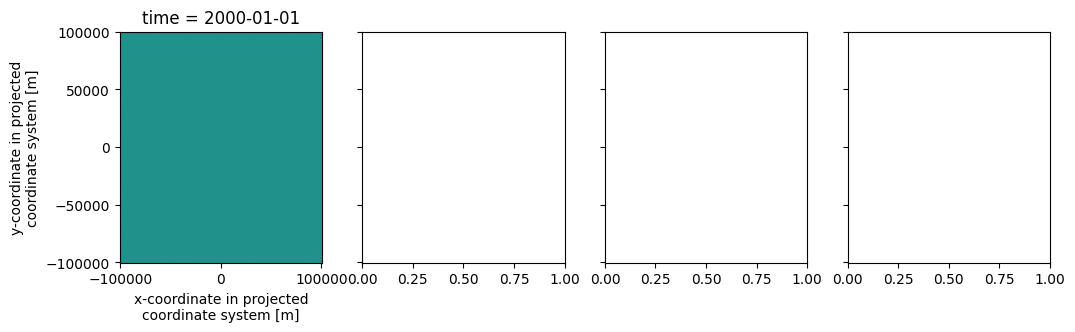

In [16]:

fig, axs = plt.subplots(1, len(dt_trajs), sharey=True, figsize=(12, 3))
for k, trajs in enumerate(dt_trajs):
    if k == len(dt_trajs)-1:
        add_cb = True
    else:
        add_cb = False
    ds["v"].plot(ax=axs[k], vmin=0, vmax=500, add_colorbar=add_cb)
    for traj in trajs:
        ps = np.array([[p.x, p.y] for p in traj]).T
        axs[k].scatter(*ps, s=0.5)
    axs[k].set_title(f"""dt={dts[k]}""")

fig, ax = plt.subplots(1, 1, figsize=(3.2, 3.2))
for k in range(len(points)):
    ax.plot(dts, [dt_trajs[n][k][0].distance(dt_trajs[n][k][-1]) for n in range(len(dt_trajs))])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("distance (m)")
ax.set_xlabel("dt (years)")

## Create doc-string examples

In [ ]:
import numpy as np
from shapely import Point

nx = 201
ny = 401
x = np.linspace(-100e3, 100e3, nx)
y = np.linspace(-100e3, 100e3, ny)
X, Y = np.meshgrid(x, y)

# Directional vectors
vx = -Y / np.sqrt(X**2 + Y**2) * 250
vy = X / np.sqrt(X**2 + Y**2) * 250

p = Point(0, -50000)

pts, pts_error_estim = compute_trajectory(p, vx, vx, x, y, dt=1, total_time=10)

In [ ]:
pts